In [2]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

In [25]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import numpy as np  

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda:1" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
torch_device 

'cuda:1'

In [4]:
torch.__version__

'2.0.1+cu118'

In [5]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding

position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

# Functions

In [6]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [7]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [8]:
def generate_with_embs(text_embeddings, text_input, seed):

    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [9]:
def generate_with_prompt_style(prompt, style, seed = 42):

    prompt = prompt + ' in style of s'
    embed = torch.load(style)

    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    # for t in text_input['input_ids'][0][:20]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    #     print(t, tokenizer.decoder.get(int(t)))
    input_ids = text_input.input_ids.to(torch_device)

    token_embeddings = token_emb_layer(input_ids)
    # The new embedding - our special birb word
    replacement_token_embedding = embed[list(embed.keys())[0]].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==338)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    return generate_with_embs(modified_output_embeddings, text_input, seed)

In [10]:
import torch

def contrast_loss(images):
    variance = torch.var(images)
    return -variance

def generate_with_prompt_style_guidance(prompt, style, seed=42):

    prompt = prompt + ' in style of s'
    
    embed = torch.load(style)

    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50  #           # Number of denoising steps
    guidance_scale = 8 #               # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    contrast_loss_scale = 200 #

    # Prep text
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    input_ids = text_input.input_ids.to(torch_device)

    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)

    # The new embedding - our special birb word
    replacement_token_embedding = embed[list(embed.keys())[0]].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, torch.where(input_ids[0]==338)] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And the uncond. input as before:
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        if i%5 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

            # Calculate loss
            loss = contrast_loss(denoised_images) * contrast_loss_scale

            # # Occasionally print it out
            # if i%10==0:
            #     print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample


    return latents_to_pil(latents)[0]

# Prompt in different styles

In [29]:
prompt = 'A man sipping wine wearing a spacesuit on the moon'

/tmp/ipykernel_124783/1473923985.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

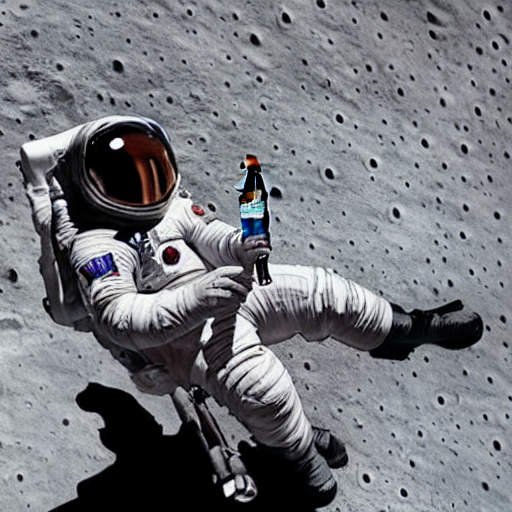

In [30]:
generate_with_prompt_style(prompt, 'styles/learned_embeds_arcane.bin')

/tmp/ipykernel_124783/1473923985.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

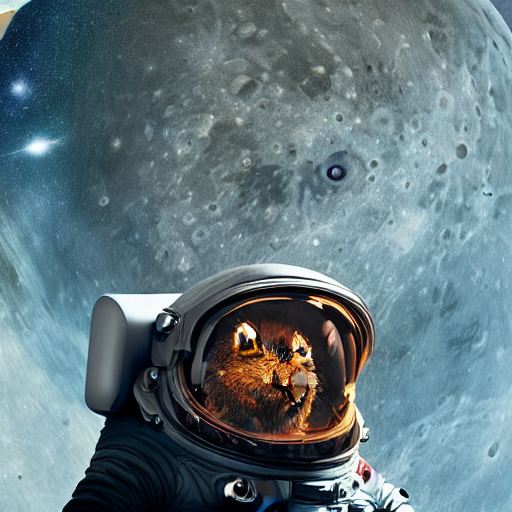

In [31]:
generate_with_prompt_style(prompt, 'styles/learned_embeds_dr_strange.bin')

/tmp/ipykernel_124783/1473923985.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

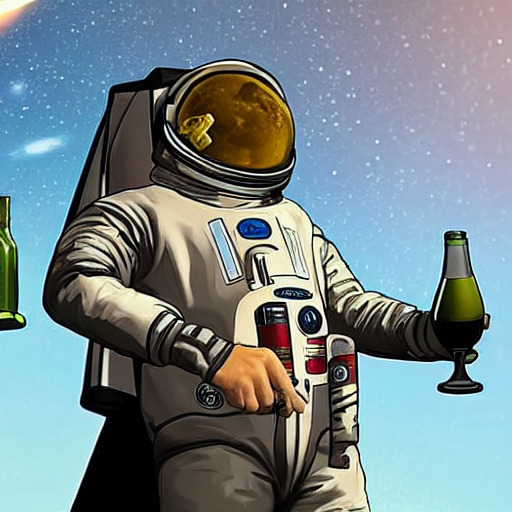

In [32]:
generate_with_prompt_style(prompt, 'styles/learned_embeds_gta5.bin')

/tmp/ipykernel_124783/1473923985.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

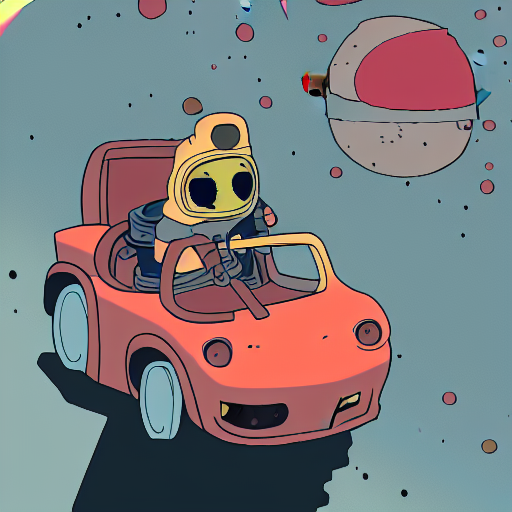

In [33]:
generate_with_prompt_style(prompt, 'styles/learned_embeds_illustration.bin')

/tmp/ipykernel_124783/1473923985.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

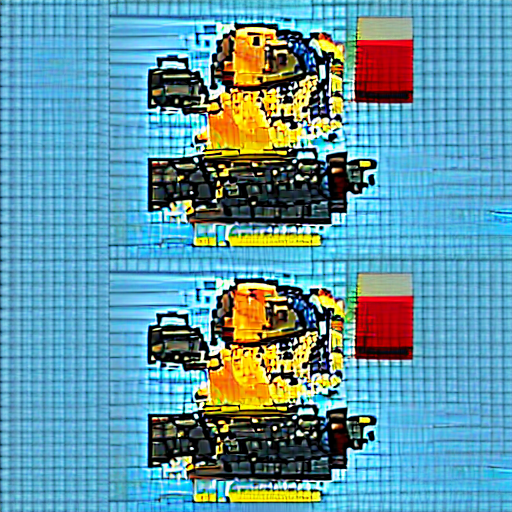

In [34]:
generate_with_prompt_style(prompt, 'styles/learned_embeds_pokemon.bin')

# With guidance

/tmp/ipykernel_124783/2875963465.py:58: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -9.18708324432373
10 loss: -27.940574645996094
20 loss: -30.385238647460938
30 loss: -32.5172233581543
40 loss: -33.18816375732422


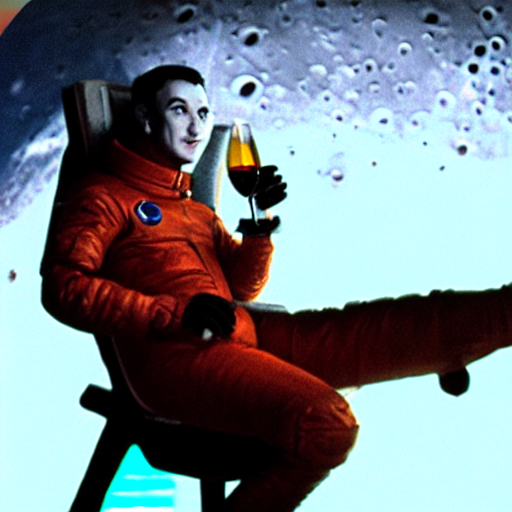

In [35]:
generate_with_prompt_style_guidance(prompt, 'styles/learned_embeds_arcane.bin')

/tmp/ipykernel_124783/2875963465.py:58: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -9.20982551574707
10 loss: -20.162492752075195
20 loss: -28.125038146972656
30 loss: -32.65557098388672
40 loss: -34.406612396240234


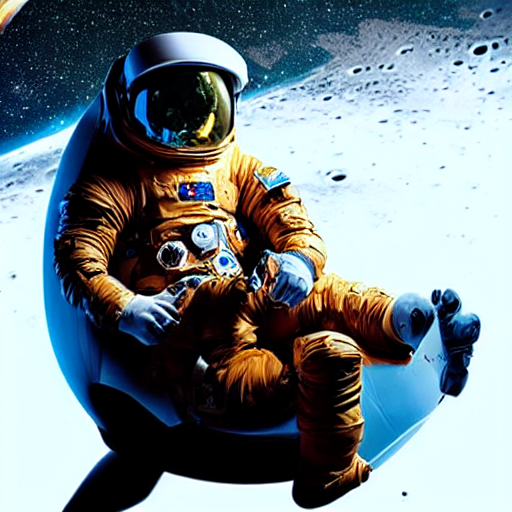

In [36]:
generate_with_prompt_style_guidance(prompt, 'styles/learned_embeds_dr_strange.bin')

/tmp/ipykernel_124783/2875963465.py:58: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -7.891202926635742
10 loss: -24.166337966918945
20 loss: -28.48380470275879
30 loss: -32.96968460083008
40 loss: -33.72564697265625


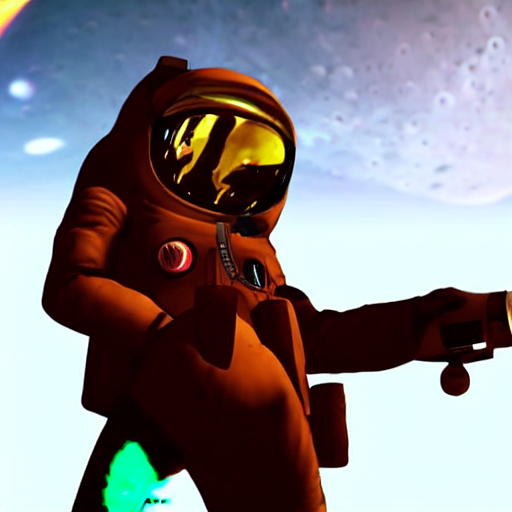

In [37]:
generate_with_prompt_style_guidance(prompt, 'styles/learned_embeds_gta5.bin')

/tmp/ipykernel_124783/2875963465.py:58: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -4.865045547485352
10 loss: -12.932589530944824
20 loss: -15.685569763183594
30 loss: -18.079195022583008
40 loss: -18.741931915283203


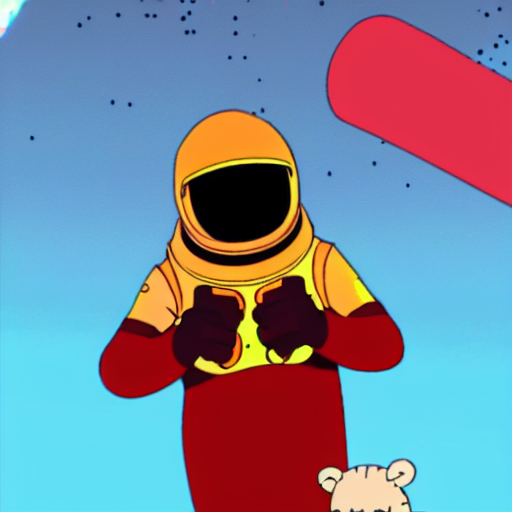

In [38]:
generate_with_prompt_style_guidance(prompt, 'styles/learned_embeds_illustration.bin')

/tmp/ipykernel_124783/2875963465.py:58: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -9.513648986816406
10 loss: -19.66506576538086
20 loss: -28.7932071685791
30 loss: -33.21437454223633
40 loss: -34.22044372558594


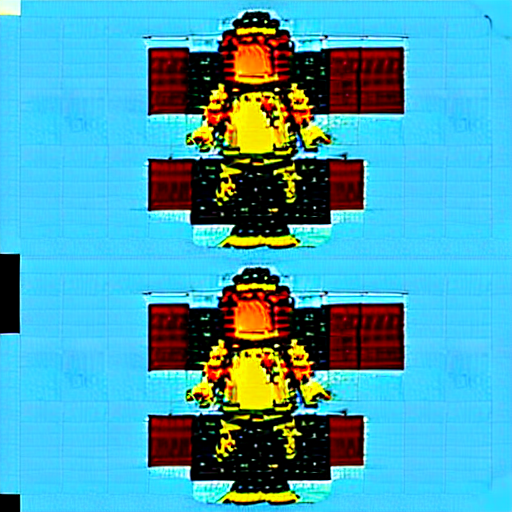

In [39]:
generate_with_prompt_style_guidance(prompt, 'styles/learned_embeds_pokemon.bin')

# Gradio app

In [43]:
import gradio as gr

In [46]:
dict_styles = {'Arcane':'styles/learned_embeds_arcane.bin', 
               'Button eyes':'styles/learned_embeds_buttoneyes.bin', 
               'Dr Strange': 'styles/learned_embeds_dr_strange.bin', 
               'GTA-5':'styles/learned_embeds_gta5.bin', 
               'Illustration': 'styles/learned_embeds_illustration.bin', 
               'Manga':'styles/learned_embeds_manga.bin', 
               'Matrix':'styles/learned_embeds_matrix.bin', 
               'Oil Painting':'styles/learned_embeds_oil.bin', 
               'Pokemon':'styles/learned_embeds_pokemon.bin', 
               'Stripes': 'styles/learned_embeds_stripe.bin'}
dict_styles.keys()

dict_keys(['Arcane', 'Button eyes', 'Dr Strange', 'GTA-5', 'Illustration', 'Manga', 'Matrix', 'Oil Painting', 'Pokemon', 'Stripes'])

In [47]:
def inference(prompt, style): 
    
    if prompt is not None and style is not None: 
        style = dict_styles[style]
        result = generate_with_prompt_style_guidance(prompt, style)
        return np.array(result)
    else:
        return None

In [49]:
title = "Stable Diffusion and Textual Inversion"
description = "A simple Gradio interface to stylize Stable Diffusion outputs"
examples = [[prompt, style] for style in dict_styles.keys()]

demo = gr.Interface(inference,
                    inputs = [gr.Textbox(label='Prompt'), 
                              gr.Dropdown(['Arcane', 'Button eyes', 'Dr Strange', 'GTA-5', 'Illustration', 
                                           'Manga', 'Matrix', 'Oil Painting', 'Pokemon', 'Stripes'], label='Style')
                              ],
                    outputs = [
                              gr.Image(label="Stable Diffusion Output"),
                              ],
                    title = title,
                    description = description,
                    examples = examples, 
                    cache_examples=True
                    )
demo.launch()
     

Caching examples at: '/home/user/Documents/lavanya/ERA/S20/gradio_cached_examples/65'
Caching example 1/10


/tmp/ipykernel_124783/2875963465.py:58: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -9.196511268615723
10 loss: -28.276124954223633
20 loss: -29.71587562561035
30 loss: -32.65309143066406
40 loss: -33.52029800415039
Caching example 2/10


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -11.528253555297852
10 loss: -24.219820022583008
20 loss: -32.864906311035156
30 loss: -35.74132537841797
40 loss: -38.17683029174805
Caching example 3/10


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -9.207538604736328
10 loss: -20.704696655273438
20 loss: -28.09276008605957
30 loss: -32.75439453125
40 loss: -34.412601470947266
Caching example 4/10


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -7.895807266235352
10 loss: -23.95587921142578
20 loss: -29.680696487426758
30 loss: -32.641353607177734
40 loss: -33.2906379699707
Caching example 5/10


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: -4.8632121086120605
10 loss: -12.995741844177246
20 loss: -16.42226219177246
30 loss: -18.364402770996094
